In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
%matplotlib inline

## Propensity Scoring (1983)

in the previous module, we discussed matching, a way of balancing covariates to make causal inference valid. However, we saw that even in the small example that we created, it was computationally expensive. As the number of covariates increases, this problem is made worse and worse. This invites alternative methods for balancing covariates. 

The method which we will discuss today is known as *propensity scoring*. At its core, propensity scoring is simply a way of balancing covariates and creating a psuedo-population, just as we saw with matching (whether it be exact or nearest-neighbor).


The **propensity score** is defined as the probability of receiving the treatment given some covariates $\textbf{x}$

$$e(X) = Pr(W=1|X) = \mathbb{E}(W|X)$$

It can be shown that this score has the property that it balances the distribution of X (only observed covariates) between the treatment groups. Combined with our strong ignorability assumptions, this score can help us to mimic the balanced covariates of an RCT.

Note that $e(X)$ is just a scalar value! If we have this score, we can now do matching/stratification/weighting and it becomes much easier since we don't have to deal with high dimensionality. 

As a technical note, the propensity score has the following property:

$$\{Y_i(1), Y_i(0)\} \perp W_i | X_i \implies \{Y_i(1), Y_i(0)\} \perp W_i | e(X_i)$$

This basically states the fact that if the potential outcomes are conditionally independent of the covariates given the treatment, then they are also conditionally independent of the propensity score. This is the property that allows us to substitute e(X) for X itself when thinking about how to balance covariates.

## How to fit propensity score

The propensity score is often fit via logistic regression (can use other machine learning models, but logistic regression does a good job most of the time). Since we are only discussing the case of binary treatments, any binary classifier that outputs a value on a continuous scale (i.e. [0,1]) will work. 

Since the purpose of this model is to find the overlap and balance covariates between treatment groups, it is not necessary to fit the best possible model. If the model underfits or overfits, it doesn't make a huge difference on the causal inference. 

The logistic regression model would look something like this:

$$ Pr(W_i = 1 | X_i) = \sigma(\beta{X_i})$$


#### Fit a propensity score model to our exapmle 

In [2]:
notification_df = pd.read_csv("./assets/causal_inf_extract.csv")

We have already actually fit a propensity score model prior to this (located in the full_propensity_score column), but we will fit another with this abbreviated set of covariates.

In [3]:
notification_df.head()

,age,notification,admission_type_label_Urgent Admission,admission_type_label_Routine Elective Admission,admission_type_label_Emergency Admission,acp_note_filed,full_propensity_score,hospice_disch,code_status
0,89.970830,False,0,0,1,0,0.027484,0,0
1,44.739224,False,0,0,1,0,0.002748,0,0
2,85.626297,False,0,0,1,0,0.021631,0,0
3,34.889035,False,1,0,0,0,0.001617,0,0
4,62.575249,False,0,0,1,0,0.006805,0,0


In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
# Initialize the model -- we'll use default parameters for now
lr = LogisticRegression()

In [6]:
lr.fit(notification_df.loc[:, ['age', 
                               'admission_type_label_Urgent Admission',
                               'admission_type_label_Routine Elective Admission',
                               'admission_type_label_Emergency Admission']].values, 
       notification_df['notification'].values)


LogisticRegression()

Now, we want to get the actual scores (note that we did not use a training/test split since we don't care about assessing error -- we want to know what the model predicts in the original training set).

In [7]:
notification_df['abbr_prop_score'] = lr.predict_proba(notification_df.loc[:, ['age', 
                               'admission_type_label_Urgent Admission',
                               'admission_type_label_Routine Elective Admission',
                               'admission_type_label_Emergency Admission']].values)[:, 1]

Text(0.5, 1.0, 'Distribution of Propensity Score across groups')

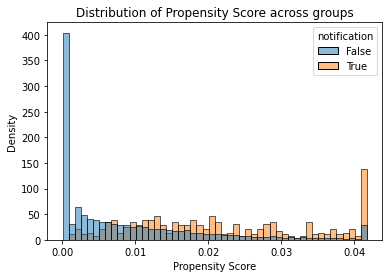

In [9]:
sns.histplot(data = notification_df, x='abbr_prop_score', hue='notification', stat='density', bins=50, common_norm=False)
plt.xlabel("Propensity Score")
plt.title("Distribution of Propensity Score across groups")

## Did we actually balance our covariates? 

The whole point of the propensity score was to balance our covariates, but we have to check if they are actually balanced. There are several proposed methods to do this. The first is to do the following procedure:

 1. create K blocks based on the propensity score quantiles
 2. For each covariate, use a t-test for the two group means
 3. Optionally run an ANOVA of X on W * b to test for main effects of W or interaction of W with b. 
 
If we did this correctly, we should not see any significance in these tests. 

## T/Z-test for each group 

In [11]:
from scipy.stats import ttest_ind as ttest
from statsmodels.stats.weightstats import ztest

In [29]:
def get_p_values(df, propensity_score_column, cov_to_test, 
                 treatment_col, test_type="t"):
    """
    Arguments:
    ----------
    df : pd.DataFrame
        Dataframe that contains the propensity scores
    propensity_score_column : str
        Name of the propensity score column
    cov_to_test : str
        Name of the covariates to test
    treatment_col : str
        Name of the treatment column
    test_type : str
        One of ["t", "z"]. The type of test to perform
    
    Returns:
    --------
    result_dict : Dict[Dict]
        A dictionary where the key the is the quantile of interest
        and the value is the p-value of the resulting test
    """
    result_dict = {}
    for i in np.linspace(0, .8, 5):
        q = np.quantile(df[propensity_score_column], i)
        q2 = np.quantile(df[propensity_score_column], i + .2)
        treatment_group_values = df.loc[(df[propensity_score_column] >= q)
                                       &(df[propensity_score_column] < q2)
                                       &(df[treatment_col] == 1),
                                         cov_to_test].values
        control_group_values = df.loc[(df[propensity_score_column] >= q)
                                     &(df[propensity_score_column] < q2)
                                     &(df[treatment_col] == 0),
                                     cov_to_test].values
        if test_type == "t":
            result_dict[q] = ttest(treatment_group_values, control_group_values).pvalue
        elif test_type == "z":
            result_dict[q] = ztest(treatment_group_values, control_group_values).pvalue
            
    return result_dict

In [30]:
get_p_values(df=notification_df,
             propensity_score_column="abbr_prop_score",
             cov_to_test="age",
             treatment_col="notification")

{2.7246428029141393e-05: nan,
 0.00025205684712226254: 0.25678520822458273,
 0.002287342354424743: 0.2339077754843437,
 0.007558387938089923: 0.010295182970900181,
 0.016160657411021972: 3.307565693394395e-05}

In [31]:
get_p_values(df=notification_df,
             propensity_score_column="full_propensity_score",
             cov_to_test="age",
             treatment_col="notification")

{0.0012522910589001022: 0.7677879846141645,
 0.0028839282218985707: 0.05840828564287145,
 0.005546834009807674: 0.2327780474886158,
 0.008689887313075885: 0.9041557823431949,
 0.013096938697729401: 2.023641300053126e-07}

## Absolute Standardized Difference [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3472075/]

$$ d = \frac{(\bar{x}_{treatment} - \bar{x}_{control})}{\sqrt{\frac{s^2_{treatment} + s^2_{control}}{2}}} $$

for continuous variables 

$$ d = \frac{(\hat{p}_{treatment} - \hat{p}_{control})}{\sqrt{\frac{\hat{p}_{treatment}(1 - \hat{p}_{treatment}) + \hat{p}_{control}(1 - \hat{p}_{control})}{2}}}$$

for binary variables 

## How do we use these? 

Remember that our goal was to create a psuedo-population where the covariates were balanced. How does the propensity score allow us to do this exactly? We will look at the case of weighting, which is a very common way to do propensity score analysis. 


### Horvitz-Thompson Weighting

This is the default propensity score weighting scheme. It is described as folows:

The weight for someone in the treatment group is $1/\hat{e}_i$ and is $1/(1-\hat{e_i})$ for someone in the control group.

The intuition is as follows:

The less likely a subject was to be sampled, then the larger population weight it should have. 